# When is the sun visible from some satellite in an atmospheric layer 20 to 80 km high?

Display on the Earth's map the sun's rays visible to the satellite and passing in a given atmospheric layer, i.e. map segments between $\vec{r}_{beam\, entry}$ and $\vec{r}_{beam\, exit}$ 
<img src="vectors.png" width=500px>

Lets formulate criteries of visibility. The satellite view looks like this (all the variables in degrees):
<img src="view_from_sat.png" width=500px>
So, the Sun is fully visible in the layer considered if 
$$r_{up} >= d - r_{sun} \,and\, r_{down} <= d + r_{sun} $$
and partially if 
$$r_{up} >= d - r_{sun} \,and\, r_{down} <= d - r_{sun} $$
$$r_{up} >= d + r_{sun} \,and\, r_{down} <= d + r_{sun} $$

Final task is to obtain such a map:
<img src="map.png" width=500px>


In [3]:
import warnings

# calculating and data containing
import numpy as np
from numpy import linalg as LA
import pandas as pd
import swifter

# time
from datetime import timezone, timedelta, datetime

# celestial bodies motion calculating
import skyfield
from skyfield.api import Topos, load
from skyfield.positionlib import Geocentric
from skyfield.nutationlib import iau2000b

# plotting
import os
os.environ['PROJ_LIB'] = r'C:\Users\Egor\AppData\Local\Continuum\anaconda2\pkgs\proj4-4.9.2-vc10_0\Library\share'
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib.tri as tri
import seaborn as sns

# multiprocessing
# from dask import dataframe as dd
# from multiprocessing import cpu_count, Pool
# import multiprocessing as mp
# from pandarallel import pandarallel
# pandarallel.initialize()

In [4]:
skyfield.__version__

'1.17'

In [5]:
lines_per_file = 2
smallfile = None
with open("iss_tle_archive.txt") as bigfile:
    for lineno, line in enumerate(bigfile):
        if lineno % lines_per_file == 0:
            if smallfile:
                smallfile.close()
            small_filename = 'small_file_{}.txt'.format(lineno + lines_per_file)
            smallfile = open(small_filename, "w")
        smallfile.write(line)
    if smallfile:
        smallfile.close()

In [8]:
# files searching
from os import listdir
from os.path import isfile, join
mypath = "C:/Users/Egor/Documents/статья с искандером/one_year_tle"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [9]:
# ISS TLEs dict forming
iss_tles = {}
for tle_filename in onlyfiles : 
    tle_filename = "C:/Users/Egor/Documents/статья с искандером/one_year_tle/" + tle_filename
    satellites = load.tle(tle_filename)
    iss_tles.update({satellites[25544].epoch.utc_datetime() : satellites[25544]})
#     iss_tles.update({satellites[25544].epoch._utc_float() : satellites[25544]})

In [10]:
# sorting ISS TLEs dict by its key - date
dates = list(iss_tles.keys())
dates.sort()
iss_tles_unsorted = iss_tles
iss_tles = {}
for date in dates:
    iss_tles.update({date : iss_tles_unsorted[date]})

In [11]:
# small test if datetime keys work in a proper way
tz = timezone(timedelta(hours=0))  # whatever your timezone offset from UTC is
date = datetime(2019, 10, 10, 0, 51, 15, 690000, tzinfo=tz)  # timezone-aware start time
date.timestamp()

1570668675.69

In [12]:
stations_url = 'http://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle(stations_url)
iss = satellites['ISS (ZARYA)']

In [13]:
planets = load('de421.bsp')
sun = planets['sun']
earth = planets['earth']

### Список задач для организации долгосрочного корректного рассчета орбиты с применением TLE-архива
Что есть:
1. есть список дат, для которых надо рассчитать движение КА. Пусть этот список называется __T__
2. есть список ключей-дат, для которых были получены TLE. Этот список называется __kT__

Что нужно сделать:
1. сформировать расчетные мини-периоды:
    1. начало - тик __T_j__, T_j-1 < kT_i <= __T_j__ < T_j+1
    2. конец - тик __T_n__, T_n-1 < __T_n__ < kT_i+1 <= T_n+1
    3. длительность периода, T_n - T_j
2. каждому такому периоду сопоставить спутник Skyfield с TLE_date __kT_i__, соотв. левой границе периода (т.е. тику __T_j__, T_j-1 < kT_i <= __T_j__ < T_j+1)
3. рассчитать движение спутника за этот период. Тут можно __параллелизовать__ задачу, т.к. периодов много. За раз можно считать 8 периодов, т.к. доступных потоков 8. Но тут у меня есть вопросы:
    1. Как согласовать потоки? Длительности периодов __разные__
    2. 
4. сложить все полученные мини-траектории для мелких участков времени в одну большую для большого временного периода
6. ???
7. PROFIT!!!

Каждому временному тику можно назначить свой спутник. В таком случае даже ручное распараллеливание не пригодится - можно будет воспользоваться параллельным .apply

All vectors are calcuted in the Geocentric Celestial Reference System (GCRS)

In [139]:
# constants
R_earth = 6371000 #m
R_sun = 0#1.392E9/2 #m

# visibility indexes
visible = {'false' : 0, 'true' : 1, 'up' : 2, 'down' : 3}

class image_plotter:
    def __init__(self, sat, sun, earth, dt=10, T=[3, 0, 0, 0], h=[20, 80], start_date=[2019, 12, 20, 0, 0, 0], GMT=0,
                sat_subpoint=False, full_sun=False):
        self.sat = sat # EarthSatellite or {datetime : EarthSatellite}
        self.sun = sun
        self.earth = earth
        self.dt = dt # time step, [seconds]
        self.T = T # time period condsidered, [days, hours, minutes, seconds]
        self.h = [h[0]*1E3, h[1]*1E3] # heights of atmospheric layer considered, initially in [km], from now in [m]
        self.start_date = start_date # [year, month, day, hour, minute, second]
        self.GMT = GMT # [hours]
        self.sat_subpoint = sat_subpoint # Does the position of the spacecraft display during the flyby?
        self.full_sun = full_sun # Only consider the full visibility of the sun or partial too?
        
        self.ts = load.timescale()
        dates = self.get_dates()
        self.df = pd.DataFrame({'Date':dates}) # vector of the dates to calculate positions of sat, 
                                               # sun and sun's visibility 
                 
    def decode_start_date(self):
        Y = self.start_date[0]
        M = self.start_date[1]
        D = self.start_date[2]
        h = self.start_date[3]
        m = self.start_date[4]
        s = self.start_date[5]
        return Y, M, D, h, m, s
    
    def decode_period(self):
        dD = self.T[0]
        dh = self.T[1]
        dm = self.T[2]
        ds = self.T[3]
        return dD, dh, dm, ds      

    def get_dates(self):
        # start date
        Y, M, D, h, m, s = self.decode_start_date()        
        # period considered
        dD, dh, dm, ds = self.decode_period()

        # getting the vector of dates
        ts = load.timescale()  # create skyfield timescale object
        tz = timezone(timedelta(hours=self.GMT))  # whatever your timezone offset from UTC is
        start = datetime(Y, M, D, h, m, s, tzinfo=tz)  # timezone-aware start time
        end = start + timedelta(seconds=ds, minutes=dm, hours=dh, days=dD)  # one day's worth of times
        delta = timedelta(seconds=self.dt)  # your interval over which you evaluate
        dates = [start]
        now = start
        while now <= end:
            now += delta
            dates.append(now)
        return dates

    def get_sun_position(self, row): # get position of the Sun  
        t = row["Date"]
        t = self.ts.utc(t) 
        t._nutation_angles = iau2000b(t.tt) # reducing accuracy of Sun's position determ. to improve speed
        pos = self.earth.at(t).observe(self.sun).apparent().position.m 
        return pos
    
    def get_sat_position_and_subpoint(self, row): # get position of sat 
                                                  # and its current latitude, longitude and elevation
        t = self.ts.utc(row["Date"])
        geocentric = row["sat"].at(t)
        row["sat_pos"] = geocentric.position.m
        subpoint = geocentric.subpoint()
        row["sat_subpoint"] = np.array([self.convert_angle(subpoint.latitude), 
                                        self.convert_angle(subpoint.longitude), subpoint.elevation.m])
        return row 
    
    def get_sat_position(self, row): # get position of sat 
        t = self.ts.utc(row["Date"])
        geocentric = row["sat"].at(t) 
        pos = geocentric.position.m
        return pos   

    def get_positions(self):
        self.df = self.df.swifter.apply(self.get_sat_for_date, axis=1)
        if self.sat_subpoint : self.df = self.df.swifter.apply(self.get_sat_position_and_subpoint, axis=1)
        else : self.df["sat_pos"] = self.df.swifter.apply(self.get_sat_position, axis=1)
        self.df["sun_pos"] = self.df.swifter.apply(self.get_sun_position, axis=1)       
        self.df["sat_to_sun"] = self.df["sun_pos"] - self.df["sat_pos"] # vector between the sat and the Sun, 
                                                                        # pointing to the Sun
        self.df = self.df.swifter.apply(self.get_WGS84_R_Earth, axis=1)

    def get_nearest_datetime(self, items, pivot):
        return min(items, key=lambda x: abs(x - pivot))

    def get_sat_for_date(self, row):
        t = row["Date"]
        t = t.to_pydatetime()
        if type(self.sat) == dict : 
            row["closest TLE date"] = self.get_nearest_datetime(self.sat.keys(), t)
            row["sat"] = self.sat[row["closest TLE date"]]
        elif type(self.sat) == skyfield.sgp4lib.EarthSatellite: 
            row["closest TLE date"] = self.sat.epoch.utc_datetime()
            row["sat"] = self.sat
        else : raise TypeError('Incorrect type of self.sat')
        return row

    def calculate_visibility(self): # compute if sun is visible for whole dataframe
        print("Shape of dataframe before determining if the Sun is visible is", self.df.shape)
        self.df = self.df.swifter.apply(self.get_horizont_earth_radius, axis=1)
        self.df["sun_vis"] = self.df.swifter.apply(self.sun_is_visible, axis=1)
        if self.full_sun : self.df = self.df[self.df["sun_vis"]==1]
        else : self.df = self.df[self.df["sun_vis"]!=0]
        self.df = self.df.reset_index(drop=True)
        print("Shape of dataframe after determining if the Sun is visible is", self.df.shape)

    def get_horizont_earth_radius(self, row):
        r_sat = row["sat_pos"]
        r_ss = row["sat_to_sun"] 
        r_ss_norm = LA.norm(r_ss)
        perpendicular_to_ss = r_sat - np.dot(r_ss / r_ss_norm, r_sat) * r_ss / r_ss_norm
        point = Geocentric(position_au=perpendicular_to_ss/149597870691, t=self.ts.utc(row["Date"])) # высота рассчитывается из WGS 84
        subpoint = point.subpoint()
        row["horizont_R_earth"] = LA.norm(perpendicular_to_ss) - subpoint.elevation.m
        return row     
        
    def sun_is_visible(self, row): # compute if the sun is visible for current date 
        # radius-vectors of sat and sun
        r_sat = row["sat_pos"]
        r_sun = row["sun_pos"]
        r_ss = row["sat_to_sun"] 
        # getting norms
        r_sat = LA.norm(r_sat)
        r_sun = LA.norm(r_sun)
        r_ss = LA.norm(r_ss)
        # angles of visibility
        rho_up = np.arcsin((row["horizont_R_earth"] + self.h[1]) / r_sat) # R_earth acceptable
        rho_down = np.arcsin((row["horizont_R_earth"] + self.h[0]) / r_sat) # R_earth acceptable
        rho_sun = np.arcsin(R_sun / r_ss)
        d = np.arccos((r_sat**2 + r_ss**2 - r_sun**2) / (2 * r_sat * r_ss))
        # determing if sun is visible
        if rho_up >= d + rho_sun and rho_down <= d - rho_sun : return visible["true"]
#         if rho_up >= d - rho_sun and rho_down <= d + rho_sun : return visible["true"]
        elif rho_up >= d - rho_sun and rho_down <= d - rho_sun : return visible["down"]
        elif rho_up >= d + rho_sun and rho_down <= d + rho_sun : return visible["up"]
        else : return visible["false"]  
        
    def get_WGS84_R_Earth(self, row):
        sat_vec = row["sat_pos"]
        lat, lon, elev = row["sat_subpoint"]
        row["WGS_84_R_Earth"] = LA.norm(sat_vec) - elev
#         row["WGS_84_R_Earth"] = R_earth
        return row      
        
    def get_entry_vec(self, row): # Light beam entry position 
        b1, b2, b3 = row["sat_to_sun"]
        c1, c2, c3 = row["sat_pos"]
        local_R_earth = row["WGS_84_R_Earth"] # constant R_Earth unacceptable. use WGS 84
        R = local_R_earth + self.h[1] 
        # from Mathematica
        a1 = (-2*b1**2*c1 - 2*b1*b2*c2 - 2*b1*b3*c3 - np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2))
        a2 = (-((b1**2*b2*c1)/(b1**2 + b2**2 + b3**2)) - (b1*b2**2*c2)/(b1**2 + b2**2 + b3**2) - (b1*b2*b3*c3)/(b1**2 + b2**2 + b3**2) - (b2*np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2)))/b1
        a3 = (-((b1**2*b3*c1)/(b1**2 + b2**2 + b3**2)) - (b1*b2*b3*c2)/(b1**2 + b2**2 + b3**2) - (b1*b3**2*c3)/(b1**2 + b2**2 + b3**2) - (b3*np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2)))/b1
        if np.isnan(a1) or np.isnan(a2) or np.isnan(a3) : return np.nan
        else : return np.array([a1, a2, a3]) + row["sat_pos"]

    def get_exit_vec(self, row): # Light beam exit position 
        b1, b2, b3 = row["sat_to_sun"]
        c1, c2, c3 = row["sat_pos"] 
        local_R_earth = row["WGS_84_R_Earth"] # constant R_Earth unacceptable. use WGS 84
        R = local_R_earth + self.h[1] 
        # from Mathematica
        a1 = (-2*b1**2*c1 - 2*b1*b2*c2 - 2*b1*b3*c3 + np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2))
        a2 = (-((b1**2*b2*c1)/(b1**2 + b2**2 + b3**2)) - (b1*b2**2*c2)/(b1**2 + b2**2 + b3**2) - (b1*b2*b3*c3)/(b1**2 + b2**2 + b3**2) + (b2*np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2)))/b1
        a3 = (-((b1**2*b3*c1)/(b1**2 + b2**2 + b3**2)) - (b1*b2*b3*c2)/(b1**2 + b2**2 + b3**2) - (b1*b3**2*c3)/(b1**2 + b2**2 + b3**2) + (b3*np.sqrt((2*b1**2*c1 + 2*b1*b2*c2 + 2*b1*b3*c3)**2 - 4*(b1**2 + b2**2 + b3**2)*(b1**2*c1**2 + b1**2*c2**2 + b1**2*c3**2 - b1**2*R**2)))/(2.*(b1**2 + b2**2 + b3**2)))/b1
        if np.isnan(a1) or np.isnan(a2) or np.isnan(a3) : return np.nan
        else : return np.array([a1, a2, a3]) + row["sat_pos"]
        
    def convert_angle(self, angle): # converts angle value from int(deg), int(min), int(sec) to float(deg)
        angle = angle.dms(warn=True)
        return angle[0] + angle[1] / 60 + angle[2] / 3600

    def beam_path_points_with_subpoints(self, row):
        num_points = row["num_points"] #- 1
        points_skyfield = []
        points = []
        ponts_direct_coords = []
        for i in range(num_points):
            point = row["entry_vec"] + row["diff"] * i
            ponts_direct_coords.append(point)
            point = Geocentric(position_au=point/149597870691, t=self.ts.utc(row["Date"])) # высота рассчитывается из WGS 84
            subpoint = point.subpoint()
            points_skyfield.append([subpoint.latitude, subpoint.longitude, subpoint.elevation.m])
            points.append([self.convert_angle(subpoint.latitude), self.convert_angle(subpoint.longitude), subpoint.elevation.m])
            
        row["beam_path_points_with_subpoints"] = np.array(points_skyfield)
        row["beam_path"] = np.array(points)
        row["beam_path_points_direct_coords"] = np.array(ponts_direct_coords)
        return row


    def get_beam_path(self, num_points=50): # generate point lying on beam path
        # get vectors, pointing to the entry to atm and to the exit from atm of light beam
        self.df["entry_vec"] = self.df.swifter.apply(self.get_entry_vec, axis=1)
        self.df["exit_vec"] = self.df.swifter.apply(self.get_exit_vec, axis=1)
        self.df = self.df.dropna()

        # get points forming light trajectory
        self.df["diff"] = self.df["exit_vec"] - self.df["entry_vec"] # оба имеют макс. высоту в h[1]. При этом на их же концах и есть наибольшая ошибка
        self.df["num_points"] = num_points
        self.df["diff"] /= self.df["num_points"]
        self.df = self.df.swifter.apply(self.beam_path_points_with_subpoints, axis=1)

        # clean data
        self.df.drop(columns=["diff"])
        self.df = self.df.reset_index(drop=True)
        
    def total_seconds(self, t):
        return t.total_seconds()
            
    def get_flyby_info(self, plot=True, lookup=True): # get information about flyby: duration [sec], start and end date
        self.df["dt"] = self.df["Date"].diff().apply(self.total_seconds)        
        Duration = []    
        Start = []
        End = []      
        for index, row in self.df.iterrows():
#             print(row)
            dt = row["dt"]
            date = row["Date"]
            if np.isnan(dt) : 
                Duration.append(0)  
                Start.append(date)
                End.append(date)
            elif dt <= 2 * self.dt : 
                Duration[-1] += dt
                if End[-1] < date : End[-1] = date
            else : 
                Duration.append(0)
                Start.append(date)
                End.append(date)
            
        assert len(Duration) == len(Start) and len(Duration) == len(End), print("Sizes of the lists must be equal! Duration", len(Duration), "Start", len(Start), "End", len(End))
        flyby_info = pd.DataFrame({"Duration" : Duration, "Start" : Start, "End" : End})  
        self.flyby_info = flyby_info
        
        if lookup : 
            flyby_info.head()
            print("Shape is ", flyby_info.shape)
            
        if plot :
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(12, 6)
            fig.suptitle('Flyby duration plots')
            ax1.plot(flyby_info["Duration"])
            ax1.set_xlabel("Number of flyby")
            ax1.set_ylabel("Duration of flyby, sec")

            ax2 = sns.distplot(flyby_info["Duration"])
            ax2.set_ylabel("Fraction")
            ax2.set_xlabel("Duration of flyby, sec")
        
        return flyby_info       
    
    def plot(self, terminator=False, sat_trajectory=False, save=False, projection='cyl', scatter=False): # get final map
        # start date
        Y, M, D, h, m, s = self.decode_start_date()        
        # period considered
        dD, dh, dm, ds = self.decode_period()
        
        # datetimes
        tz = timezone(timedelta(hours=self.GMT))  # whatever your timezone offset from UTC is
        date = datetime(Y, M, D, h, m, s, tzinfo=tz)  # timezone-aware start time
        ddate = timedelta(days=dD, hours=dh, minutes=dm, seconds=ds)
        date_mid = date + ddate / 2
        print("Start date is", date)
        print("Middle date is", date_mid)
        print("Final date is", date + ddate)    

        # prepare data for plotting
        # beam path points
        ar = np.array(self.df["beam_path"][0])
        for i in self.df["beam_path"]:
            ar = np.concatenate((ar, i), axis=0)
#         ar = ar[np.logical_and(ar[:,2] > self.h[0]*0.98, ar[:,2] < self.h[1]*1.02)]
#         ar = ar[ar[:,2] < self.h[1]*1.02]

        # satellite trajectory points 
        if sat_trajectory : 
            sat = np.array(self.df["sat_subpoint"][0])
            sat = sat[np.newaxis]
            for i in self.df["sat_subpoint"]:
                i = i[np.newaxis]
                sat = np.concatenate((sat, i), axis=0)
            
        # plotting
        # map
#         fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        fig = plt.figure(figsize=(12, 6), edgecolor='w')
        ax = fig.add_axes([0,0,1,1])
        mp = Basemap(projection=projection, lat_0=0, lon_0=0, ax=ax)

        # relief, water and etc.
        mp.drawcoastlines(color='gray', zorder=0)
        mp.shadedrelief(zorder=0)

        # plotting terminator
        if terminator : 
            term_speed = 360./(24*3600)
            total_sec = dD * 24 * 3600 + dh * 3600 + dm * 60 + ds
            print("During the considered time period, the terminator shifts by", term_speed * total_sec, "degrees.")
            print("Position of the terminator for the middle of the period is shown.")
            CS=mp.nightshade(date_mid, zorder=1)

        # plotting atmospheric cut 
        lons = ar[:, 1]
        lats = ar[:, 0]
        elev = ar[:, 2]
        print("min elev of the beam =", min(elev), "m , max elev of the beam =", max(elev), "m")
        x, y = mp(lons, lats)
        if scatter :lol = mp.scatter(x, y, marker=".", c=elev/1000, s=2) #cmap="plasma",
        else : lol = ax.tricontourf(x, y, elev/1000, levels=15)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.2)
        cbar = fig.colorbar(lol, cax=cax)
        cbar.set_label('Beam elevation, km', rotation=90)

        # plotting sattelite trajectory
        if sat_trajectory : 
            lats = sat[:, 0]
            lons = sat[:, 1]
            elev = sat[:, 2]
            x, y = mp(lons, lats)
            lol = mp.scatter(x, y, marker=".", c='red', s=4)

        # saving
        if save : 
            plt.savefig('map.png', quality=100, dpi=300, bbox_inches='tight')
            print("The image has been saved.")
            
        # showing
        plt.show()
        
    def __call__(self, terminator=True, sat_trajectory=True, save=False, projection='cyl', scatter=True, num_points=40, plot_flyby_info=False): # operating pipeline
        self.get_positions()
        self.calculate_visibility()
        self.get_flyby_info(plot=plot_flyby_info) 
        self.get_beam_path(num_points=num_points)
        self.plot(terminator=terminator, sat_trajectory=sat_trajectory, save=save, projection=projection, scatter=scatter)      
 

In [166]:
# ip = image_plotter(iss_tles, sun, earth, dt=30, T=[365, 0, 0, 0], h=[20, 80], start_date=[2020, 5, 16, 2, 28, 0], sat_subpoint=True, full_sun=False)
# ip();
ip = image_plotter(iss_tles, sun, earth, dt=30, T=[14, 0, 0, 0], h=[20, 80], start_date=[2020, 5, 15, 21, 46, 0], sat_subpoint=True, full_sun=False)


In [167]:
%%time
# this cell operating really slow, especially when calculating long time period
ip.get_positions()

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



Wall time: 6min 16s


In [168]:
%%time
ip.calculate_visibility()

Shape of dataframe before determining if the Sun is visible is (40322, 8)



Shape of dataframe after determining if the Sun is visible is (1293, 10)
Wall time: 1min 24s


Shape is  (391, 3)


,Duration,Start,End
0,600.0,2020-05-15 21:50:30+00:00,2020-05-15 22:00:30+00:00
1,600.0,2020-05-15 23:23:30+00:00,2020-05-15 23:33:30+00:00
2,570.0,2020-05-16 00:57:00+00:00,2020-05-16 01:06:30+00:00
3,540.0,2020-05-16 02:30:30+00:00,2020-05-16 02:39:30+00:00
4,540.0,2020-05-16 04:03:30+00:00,2020-05-16 04:12:30+00:00
...,...,...,...
386,0.0,2020-05-29 17:23:30+00:00,2020-05-29 17:23:30+00:00
387,0.0,2020-05-29 17:59:00+00:00,2020-05-29 17:59:00+00:00
388,0.0,2020-05-29 19:32:00+00:00,2020-05-29 19:32:00+00:00
389,0.0,2020-05-29 20:29:00+00:00,2020-05-29 20:29:00+00:00


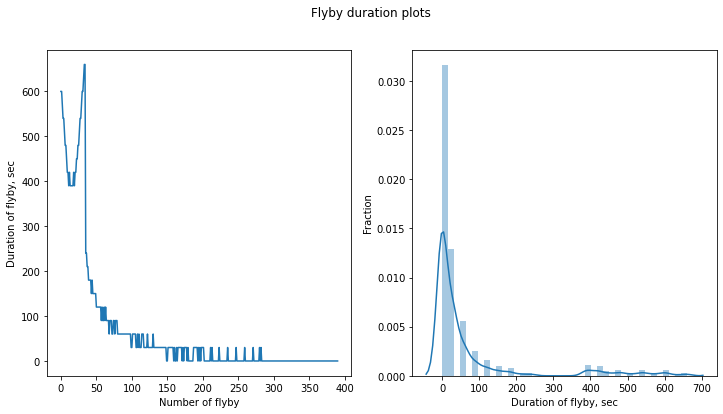

In [169]:
ip.get_flyby_info() 

In [174]:
%%time
ip.get_beam_path(num_points=30)


Wall time: 42.9 s


In [ ]:
ip.plot(terminator=False, sat_trajectory=False, scatter=True, save=False)

Start date is 2020-05-15 21:46:00+00:00
Middle date is 2020-05-22 21:46:00+00:00
Final date is 2020-05-29 21:46:00+00:00



In [131]:
ip.df['beam_path_points_with_subpoints'][300]

array([[<Angle 59deg 40' 50.6">, <Angle 00deg 46' 06.5">,
        88764.6375410326],
       [<Angle 60deg 07' 37.9">, <Angle 00deg 17' 23.2">,
        81417.30437171023],
       [<Angle 60deg 34' 22.2">, <Angle -00deg 12' 11.3">,
        74577.29267841125],
       [<Angle 61deg 01' 03.0">, <Angle -00deg 42' 39.0">,
        68246.18140752829],
       [<Angle 61deg 27' 39.5">, <Angle -01deg 14' 02.0">,
        62425.435664709075],
       [<Angle 61deg 54' 11.3">, <Angle -01deg 46' 22.5">,
        57116.405041714395],
       [<Angle 62deg 20' 37.6">, <Angle -02deg 19' 42.9">,
        52320.322067874724],
       [<Angle 62deg 46' 57.8">, <Angle -02deg 54' 05.7">,
        48038.300790224836],
       [<Angle 63deg 13' 11.2">, <Angle -03deg 29' 33.2">,
        44271.33548607303],
       [<Angle 63deg 39' 17.1">, <Angle -04deg 06' 08.2">,
        41020.29951150656],
       [<Angle 64deg 05' 14.8">, <Angle -04deg 43' 53.3">,
        38285.9442888569],
       [<Angle 64deg 31' 03.5">, <Angle -05

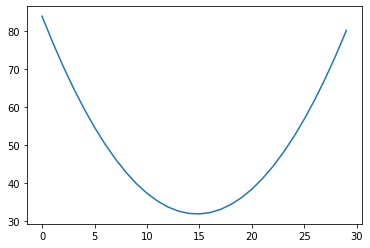

In [150]:
plt.plot(ip.df['beam_path_points_with_subpoints'][300][:, 2]/1000)

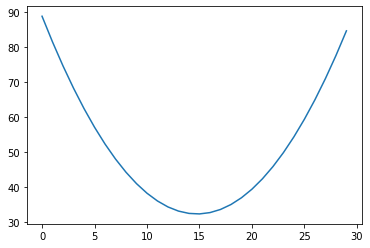

In [132]:
plt.plot(ip.df['beam_path_points_with_subpoints'][300][:, 2]/1000)

In [133]:
LA.norm(ip.df["entry_vec"][300]) - R_earth

79999.99999999907

In [121]:
ip.df["beam_path"][300]

array([[ 5.96807323e+01,  7.68476792e-01,  8.87646375e+04],
       [ 6.01272060e+01,  2.89778217e-01,  8.14173044e+04],
       [ 6.05728469e+01, -2.03132032e-01,  7.45772927e+04],
       [ 6.10174941e+01, -7.10820056e-01,  6.82461814e+04],
       [ 6.14609808e+01, -1.23387712e+00,  6.24254357e+04],
       [ 6.19031346e+01, -1.77292056e+00,  5.71164050e+04],
       [ 6.23437772e+01, -2.32859472e+00,  5.23203221e+04],
       [ 6.27827242e+01, -2.90157178e+00,  4.80383008e+04],
       [ 6.32197846e+01, -3.49255255e+00,  4.42713355e+04],
       [ 6.36547609e+01, -4.10226728e+00,  4.10202995e+04],
       [ 6.40874485e+01, -4.73147622e+00,  3.82859443e+04],
       [ 6.45176357e+01, -5.38097021e+00,  3.60688984e+04],
       [ 6.49451031e+01, -6.05157101e+00,  3.43696670e+04],
       [ 6.53696235e+01, -6.74413152e+00,  3.31886311e+04],
       [ 6.57909616e+01, -7.45953570e+00,  3.25260470e+04],
       [ 6.62088735e+01, -8.19869825e+00,  3.23820463e+04],
       [ 6.66231063e+01, -8.96256398e+00

In [135]:
coords = []
for row in ip.df["beam_path_points_direct_coords"][300]:
    coords.append(LA.norm(row))
np.array(coords)

array([6451000.        , 6443507.51009558, 6436523.90344476,
       6430050.83812506, 6424089.85743734, 6418642.38809775,
       6413709.73855542, 6409293.09744026, 6405393.53214536,
       6402011.98754761, 6399149.28487032, 6396806.12069093,
       6394983.06609649, 6393680.56598954, 6392898.93854604,
       6392638.37482721, 6392898.93854604, 6393680.56598954,
       6394983.06609649, 6396806.12069093, 6399149.28487032,
       6402011.98754761, 6405393.53214536, 6409293.09744026,
       6413709.73855542, 6418642.38809775, 6424089.85743734,
       6430050.83812506, 6436523.90344476, 6443507.51009558])

In [136]:
ip.df["beam_path_points_with_subpoints"][300][:, 2]

array([88764.6375410326, 81417.30437171023, 74577.29267841125,
       68246.18140752829, 62425.435664709075, 57116.405041714395,
       52320.322067874724, 48038.300790224836, 44271.33548607303,
       41020.29951150656, 38285.9442888569, 36068.89843589368,
       34369.66703908851, 33188.631072876226, 32526.046966539176,
       32382.046319789362, 32756.63576784807, 33649.69699628869,
       35060.9869056457, 36990.13792514519, 39436.658474768075,
       42399.93357420069, 45879.22559703738, 49873.67516802138,
       54382.30220086854, 59404.00707379109, 64937.57193942571,
       70981.66216569301, 77534.82790358824, 84595.50577774913],
      dtype=object)

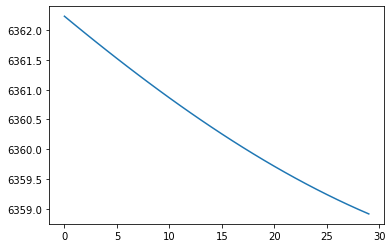

In [138]:
plt.plot((np.array(coords) - ip.df["beam_path_points_with_subpoints"][300][:, 2])/1000)

In [21]:
ip.df = pd.read_csv("oct_10_2019-oct_08_2020_fb_info_10sec.txt")

In [30]:
ip.df["Date"] = pd.to_datetime(ip.df["Date"])

Shape is  (11031, 3)


,Duration,Start,End
0,10.0,2019-10-10 00:50:30+00:00,2019-10-10 00:50:40+00:00
1,10.0,2019-10-10 01:24:20+00:00,2019-10-10 01:24:30+00:00
2,30.0,2019-10-10 02:23:10+00:00,2019-10-10 02:23:40+00:00
3,20.0,2019-10-10 02:57:10+00:00,2019-10-10 02:57:30+00:00
4,20.0,2019-10-10 03:56:10+00:00,2019-10-10 03:56:30+00:00
...,...,...,...
11026,20.0,2020-10-08 20:37:10+00:00,2020-10-08 20:37:30+00:00
11027,30.0,2020-10-08 21:36:50+00:00,2020-10-08 21:37:20+00:00
11028,20.0,2020-10-08 22:10:00+00:00,2020-10-08 22:10:20+00:00
11029,30.0,2020-10-08 23:09:50+00:00,2020-10-08 23:10:20+00:00


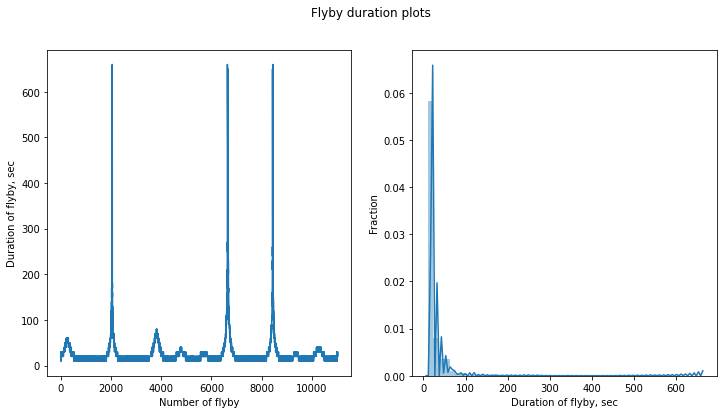

In [31]:
ip.get_flyby_info() 

In [36]:
ip.flyby_info["Duration"][ip.flyby_info["Duration"]==660]

2046    660.0
6637    660.0
8454    660.0
Name: Duration, dtype: float64

In [38]:
ip.flyby_info[6637:6638]

,Duration,Start,End
6637,660.0,2020-05-15 21:50:00+00:00,2020-05-15 22:01:00+00:00


Text(0, 0.5, 'Duration of flyby, sec')

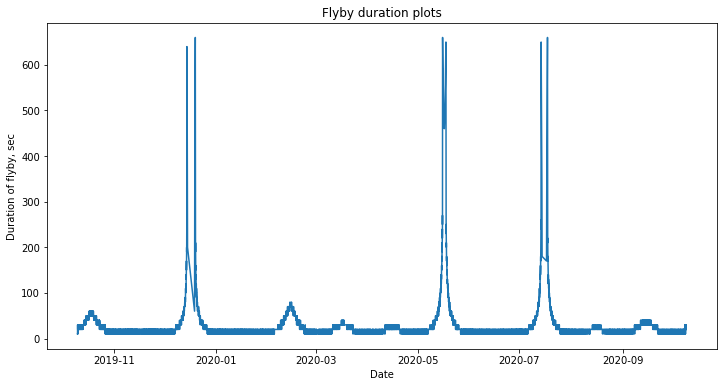

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.set_title('Flyby duration plots')
ax.plot(ip.flyby_info["Start"], ip.flyby_info["Duration"])
ax.set_xlabel("Date")
ax.set_ylabel("Duration of flyby, sec")
# ax.set_yscale('log')


# ax1.plot(flyby_info["Duration"])
# ax1.set_xlabel("Number of flyby")
# ax1.set_ylabel("Duration of flyby, sec")

# ax2 = sns.distplot(flyby_info["Duration"])
# ax2.set_ylabel("Fraction")
# ax2.set_xlabel("Duration of flyby, sec")